<a id='top'></a>

# The Guardian Player Recorded Transfer Fees Data Engineering
##### Notebook to engineer player recorded transfer data scraped from [The Guardian](https://www.theguardian.com/football/ng-interactive/2021/jun/07/mens-transfer-window-summer-2021-all-deals-from-europes-top-five-leagues).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 22/08/2021<br>
Notebook last updated: 06/09/2021

![title](../../img/logos/the-guardian-logo.png)

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers transfer data data from the [Guardian](https://www.theguardian.com/football/ng-interactive/2021/jun/07/mens-transfer-window-summer-2021-all-deals-from-europes-top-five-leagues) provided by [Tom Worville](https://twitter.com/Worville/) (see Tweet [[link](https://twitter.com/Worville/status/1420035521988993034)]), and manipulates this landed data as DataFrames using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/) for visualisation.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Flatten lists
from functools import reduce

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Currency Convert
from forex_python.converter import CurrencyRates

# APIs
from tyrone_mings import * 

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Dictionaries

In [4]:
# Defined Dictionaries

## Seasons
dict_seasons = {2016: '2016/2017',
                2017: '2017/2018',
                2018: '2018/2019',
                2019: '2019/2020',
                2020: '2020/2021',
                2021: '2021/2022'
               }

## Positions
dict_positions_grouped = {'GK': 'Goalkeeper',
                          'D': 'Defender',
                          'M': 'Midfielder',
                          'W': 'Forward',    # I think 'W' in the dataset is 'Winger', therefore a forward
                          'F': 'Forward',
                      }

### Defined Filepaths

In [5]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_guardian = os.path.join(base_dir, 'data', 'guardian')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [6]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook is part of a series of notebooks to scrape, parse, engineer, unify, and the model, culminating in a an Expected Transfer (xTransfer) player performance vs. valuation model. This model aims to determine the under- and over-performing players based on their on-the-pitch output against transfer fee and wages.

This particular notebook is one of several data engineering notebooks, that cleans recorded transfer fee player data from [Guardian](https://www.theguardian.com/football/ng-interactive/2021/jun/07/mens-transfer-window-summer-2021-all-deals-from-europes-top-five-leagues) using [pandas](http://pandas.pydata.org/).

This notebook, along with the other notebooks in this project workflow are shown in the following diagram:

![roadmap](../../img/football_analytics_data_roadmap.png)

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [FBref Player Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Player%20Stats%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Valuation Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Valuation%20Web%20Scraping.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Webscraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
     +    [FBref Team Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Team%20Stats%20Web%20Scraping.ipynb)
*    [Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [FBref Player Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Valuation Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Valuation%20Data%20Engineering.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Guardian Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Guardian%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
     +    [FBref Team Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Team%20Stats%20Data%20Engineering.ipynb)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
     +    [TransferMarkt Team Recorded Transfer Fee Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Team%20Recorded%20Transfer%20Fee%20Data%20Engineering.ipynb) (aggregated from [TransferMarkt Player Recorded Transfer Fees notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb))
     +    [Capology Team Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Team%20Salary%20Data%20Engineering.ipynb) (aggregated from [Capology Player Salary notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb))
*    [Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +    [Golden ID for Player Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Player%20Level%20Datasets.ipynb)
     +    [Golden ID for Team Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Team%20Level%20Datasets.ipynb)
*    [Production Datasets](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets)
     +    [Player Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Player%20Performance/Market%20Value%20Dataset.ipynb)
     +    [Team Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Team%20Performance/Market%20Value%20Dataset.ipynb)
*    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling)
     +    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling/Expected%20Transfer%20%20Modeling.ipynb)

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionaries</a>
The [Guardian](https://www.theguardian.com/football/ng-interactive/2021/jun/07/mens-transfer-window-summer-2021-all-deals-from-europes-top-five-leagues) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `position_number`    | object     |
| `position_description`    | object     |
| `name`    | object     |
| `dob`    | object     |
| `nationality`    | object     |
| `value`    | object     |

<a id='section3.3'></a>

### <a id='#section332'>3.3. Read in Data</a>

In [7]:
## Filename
file_name = 'guardian_transfer_data'

In [8]:
# Import DataFrame as a CSV file
df_guardian_transfers_all_raw = pd.read_csv(data_dir_guardian + f'/raw/' + f'{file_name}_latest.csv')

### <a id='#section3.3'>3.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [9]:
# Display the first 5 rows of the raw DataFrame, df_guardian_transfers_all_raw
df_guardian_transfers_all_raw.head()

,transfer_id,transfer_year,window_day,window_open,timestamp,player_name,transfer_status,transfer_type,primary_player_position,price_in_pounds,previous_club,new_club,previous_league,new_league,big_deal,flow_id
0,1,2021,48,2021-06-09,2021-07-27,Zito Luvumbo,done deal,loan,W,NaN,Cagliari,Como,Serie A,Serie C,NaN,100
1,2,2021,48,2021-06-09,2021-07-27,David Juncà,done deal,free,D,NaN,Celta Vigo,Girona,La Liga,Spanish Segunda,NaN,241
2,1,2021,48,2021-06-09,2021-07-27,Giuseppe Pezzella,done deal,loan,D,NaN,Parma,Atalanta,Serie B,Serie A,NaN,106
3,1,2021,48,2021-06-09,2021-07-27,Pablo Rosario,done deal,fee,M,5130000.0,PSV Eindhoven,Nice,Eredivisie,Ligue 1,Yes,8
4,1,2021,48,2021-06-09,2021-07-27,Martín Calderón,done deal,undisclosed,M,NaN,Real Madrid,Cádiz,La Liga,La Liga,NaN,265


In [10]:
# Display the last five rows of the raw DataFrame, df_guardian_transfers_all_raw
df_guardian_transfers_all_raw.tail()

,transfer_id,transfer_year,window_day,window_open,timestamp,player_name,transfer_status,transfer_type,primary_player_position,price_in_pounds,previous_club,new_club,previous_league,new_league,big_deal,flow_id
7214,1,2017,-38,2017-07-01,2017-05-24,Joey Barton,done deal,released,NaN,0.0,Burnley,Free agent,Premier League,Free agent,No,2
7215,1,2017,-38,2017-07-01,2017-05-24,Matthias Ostrzolek,done deal,fee,NaN,0.0,Hamburg,Hannover 96,1. Bundesliga,1. Bundesliga,No,1
7216,1,2017,-38,2017-07-01,2017-05-24,Benoît Trémoulinas,done deal,released,NaN,0.0,Sevilla,Free agent,La Liga,Free agent,No,1
7217,1,2017,-38,2017-07-01,2017-05-24,Youri Tielemans,done deal,fee,NaN,21600000.0,Anderlecht,Monaco,Belgian Jupiler Pro League,Ligue 1,Yes,1
7218,1,2017,-39,2017-07-01,2017-05-23,Juan Cuadrado,done deal,fee,NaN,17330000.0,Chelsea,Juventus,Premier League,Serie A,Yes,1


In [11]:
# Print the shape of the raw DataFrame, df_guardian_transfers_all_raw
print(df_guardian_transfers_all_raw.shape)

(7219, 16)


In [12]:
# Print the column names of the raw DataFrame, df_guardian_transfers_all_raw
print(df_guardian_transfers_all_raw.columns)

Index(['transfer_id', 'transfer_year', 'window_day', 'window_open',
       'timestamp', 'player_name', 'transfer_status', 'transfer_type',
       'primary_player_position', 'price_in_pounds', 'previous_club',
       'new_club', 'previous_league', 'new_league', 'big_deal', 'flow_id'],
      dtype='object')


The dataset has twelve features (columns).

In [13]:
# Data types of the features of the raw DataFrame, df_guardian_transfers_all_raw
df_guardian_transfers_all_raw.dtypes

transfer_id                  int64
transfer_year                int64
window_day                   int64
window_open                 object
timestamp                   object
player_name                 object
transfer_status             object
transfer_type               object
primary_player_position     object
price_in_pounds            float64
previous_club               object
new_club                    object
previous_league             object
new_league                  object
big_deal                    object
flow_id                      int64
dtype: object

In [14]:
# Info for the raw DataFrame, df_guardian_transfers_all_raw
df_guardian_transfers_all_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7219 entries, 0 to 7218
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transfer_id              7219 non-null   int64  
 1   transfer_year            7219 non-null   int64  
 2   window_day               7219 non-null   int64  
 3   window_open              7219 non-null   object 
 4   timestamp                7219 non-null   object 
 5   player_name              7219 non-null   object 
 6   transfer_status          7216 non-null   object 
 7   transfer_type            7219 non-null   object 
 8   primary_player_position  5614 non-null   object 
 9   price_in_pounds          2077 non-null   float64
 10  previous_club            7219 non-null   object 
 11  new_club                 7219 non-null   object 
 12  previous_league          7216 non-null   object 
 13  new_league               7217 non-null   object 
 14  big_deal                

In [15]:
# Description of the raw DataFrame, df_guardian_transfers_all_raw, showing some summary statistics for each numberical column in the DataFrame
df_guardian_transfers_all_raw.describe()

,transfer_id,transfer_year,window_day,price_in_pounds,flow_id
count,7219.000000,7219.000000,7219.000000,2.077000e+03,7219.000000
mean,1.033523,2018.758692,45.576673,8.547637e+06,65.337443
std,0.183817,1.287752,33.319495,1.270805e+07,83.022501
min,1.000000,2017.000000,-47.000000,0.000000e+00,1.000000
25%,1.000000,2018.000000,21.000000,1.800000e+06,7.000000
50%,1.000000,2019.000000,45.000000,4.400000e+06,28.000000
75%,1.000000,2020.000000,68.000000,1.052000e+07,95.000000
max,3.000000,2021.000000,216.000000,1.980000e+08,425.000000


<AxesSubplot:>

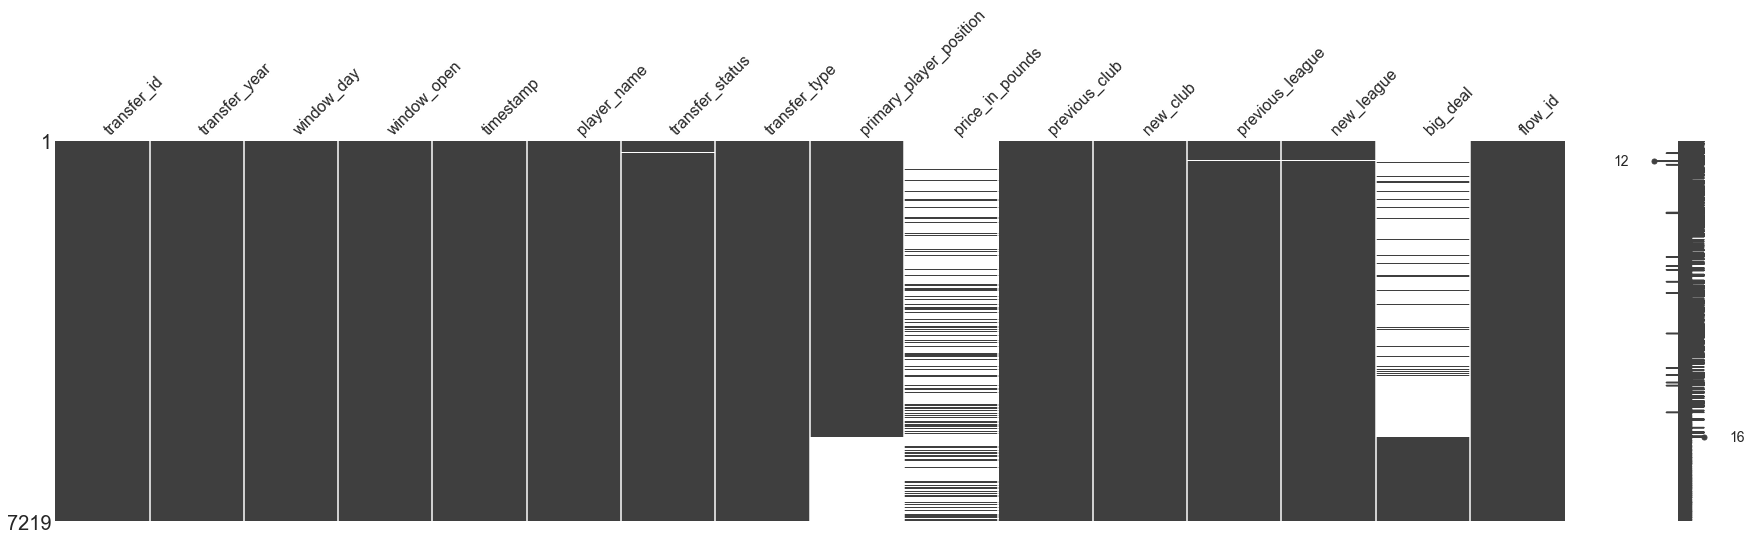

In [16]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_guardian_transfers_all_raw
msno.matrix(df_guardian_transfers_all_raw, figsize = (30, 7))

In [17]:
# Counts of missing values
null_value_stats = df_guardian_transfers_all_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

transfer_status               3
primary_player_position    1605
price_in_pounds            5142
previous_league               3
new_league                    2
big_deal                   5026
dtype: int64

The visualisation shows us very quickly that there a few missing values in the ... columns.

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Assign Raw DataFrames to New Engineered DataFrames</a>

In [18]:
# Assign Raw DataFrames to new Engineered DataFrames
df_guardian_transfers_all = df_guardian_transfers_all_raw.copy()

In [19]:
df_guardian_transfers_all.head()

,transfer_id,transfer_year,window_day,window_open,timestamp,player_name,transfer_status,transfer_type,primary_player_position,price_in_pounds,previous_club,new_club,previous_league,new_league,big_deal,flow_id
0,1,2021,48,2021-06-09,2021-07-27,Zito Luvumbo,done deal,loan,W,NaN,Cagliari,Como,Serie A,Serie C,NaN,100
1,2,2021,48,2021-06-09,2021-07-27,David Juncà,done deal,free,D,NaN,Celta Vigo,Girona,La Liga,Spanish Segunda,NaN,241
2,1,2021,48,2021-06-09,2021-07-27,Giuseppe Pezzella,done deal,loan,D,NaN,Parma,Atalanta,Serie B,Serie A,NaN,106
3,1,2021,48,2021-06-09,2021-07-27,Pablo Rosario,done deal,fee,M,5130000.0,PSV Eindhoven,Nice,Eredivisie,Ligue 1,Yes,8
4,1,2021,48,2021-06-09,2021-07-27,Martín Calderón,done deal,undisclosed,M,NaN,Real Madrid,Cádiz,La Liga,La Liga,NaN,265


### <a id='#section4.2'>4.2. String Cleaning</a>

##### Player

In [20]:
# Remove accents and create lowercase name
df_guardian_transfers_all['player_name_lower'] = (df_guardian_transfers_all['player_name']
                                                          .str.normalize('NFKD')
                                                          .str.encode('ascii', errors='ignore')
                                                          .str.decode('utf-8')
                                                          .str.lower()
                                                     )

In [21]:
# First Name Lower
df_guardian_transfers_all['first_name_lower'] = df_guardian_transfers_all['player_name_lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_guardian_transfers_all['last_name_lower'] = df_guardian_transfers_all['player_name_lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_guardian_transfers_all['first_initial_lower'] = df_guardian_transfers_all['player_name_lower'].astype(str).str[0]

##### Season

In [22]:
# Map season to DataFrame
df_guardian_transfers_all['season'] = df_guardian_transfers_all['transfer_year'].map(dict_seasons)

In [23]:
df_guardian_transfers_all.head()

,transfer_id,transfer_year,window_day,window_open,timestamp,player_name,transfer_status,transfer_type,primary_player_position,price_in_pounds,previous_club,new_club,previous_league,new_league,big_deal,flow_id,player_name_lower,first_name_lower,last_name_lower,first_initial_lower,season
0,1,2021,48,2021-06-09,2021-07-27,Zito Luvumbo,done deal,loan,W,NaN,Cagliari,Como,Serie A,Serie C,NaN,100,zito luvumbo,zito,luvumbo,z,2021/2022
1,2,2021,48,2021-06-09,2021-07-27,David Juncà,done deal,free,D,NaN,Celta Vigo,Girona,La Liga,Spanish Segunda,NaN,241,david junca,david,junca,d,2021/2022
2,1,2021,48,2021-06-09,2021-07-27,Giuseppe Pezzella,done deal,loan,D,NaN,Parma,Atalanta,Serie B,Serie A,NaN,106,giuseppe pezzella,giuseppe,pezzella,g,2021/2022
3,1,2021,48,2021-06-09,2021-07-27,Pablo Rosario,done deal,fee,M,5130000.0,PSV Eindhoven,Nice,Eredivisie,Ligue 1,Yes,8,pablo rosario,pablo,rosario,p,2021/2022
4,1,2021,48,2021-06-09,2021-07-27,Martín Calderón,done deal,undisclosed,M,NaN,Real Madrid,Cádiz,La Liga,La Liga,NaN,265,martin calderon,martin,calderon,m,2021/2022


##### Position

In [24]:
lst_postions = list(df_guardian_transfers_all['primary_player_position'].unique())
lst_postions

['W', 'D', 'M', 'F', 'GK', nan]

In [25]:
# Map grouped positions to DataFrame
df_guardian_transfers_all['primary_player_position_grouped'] = df_guardian_transfers_all['primary_player_position'].map(dict_positions_grouped)

##### Goalkeeper / Outfielder

In [26]:
# Separate Goalkeeper and Outfielders
df_guardian_transfers_all['outfielder_goalkeeper'] = np.where(df_guardian_transfers_all['primary_player_position_grouped'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')

### <a id='#section4.3'>4.3. Filter Players in 'Big 5' European Leagues and MLS</a>

In [27]:
lst_leagues = list(df_guardian_transfers_all['new_league'].unique())
lst_leagues

['Serie C',
 'Spanish Segunda',
 'Serie A',
 'Ligue 1',
 'La Liga',
 'Serie B',
 'Qatar Stars League',
 'Premier League',
 'Portugal Liga NOS',
 'Serie D',
 '3. Bundesliga',
 'Scottish Premiership',
 'Ligue 2',
 'National',
 'Swiss Challenge League',
 'MLS',
 'National 2',
 '2. Bundesliga',
 'Bayern Regionaliga',
 '1. Bundesliga',
 'Turkish Super Lig',
 'League One',
 'Championship',
 'Segunda B',
 'Danish SuperLiga',
 'Russian Premier League',
 'National League',
 'Belgian Jupiler Pro League',
 'Eredivisie',
 'Saudi Professional League',
 'Swiss Superleague',
 'UAE Gulf League',
 'J League',
 'Austrian Bundesliga',
 'Croatian 1.HNL',
 'Free agent',
 'NL South',
 'Austrian Bundeliga',
 'K-League',
 'Greek Super League',
 'Super League',
 'League Two',
 'Liga MX',
 'Austrian 2. Liga',
 'Polish Ekstraklasa',
 'Dutch Kampioen Divisie',
 'Fortuna Liga',
 'Romanian Liga 1',
 'Serbian Super Liga',
 nan,
 'Brazilian Serie A',
 'Estonian League',
 'Ukrainian Premier League',
 'Colombian Primer

In [28]:
# Filter plays in the 'Big 5' European Leagues and MLS

## Define list of countries
lst_big5_mls_leagues = ['Serie A', 'Ligue 1', 'La Liga', 'Premier League', '1. Bundesliga', 'MLS']

In [30]:
df_guardian_transfers_all['previous_league_isbig5'] = np.where(df_guardian_transfers_all['previous_league'].isin(lst_big5_mls_leagues), True, False)
df_guardian_transfers_all['new_league_isbig5'] = np.where(df_guardian_transfers_all['new_league'].isin(lst_big5_mls_leagues), True, False)
df_guardian_transfers_all['isbig5transfer'] = np.where((df_guardian_transfers_all['previous_league_isbig5'] == True) | (df_guardian_transfers_all['new_league_isbig5'] == True), True, False)
df_guardian_transfers_all = df_guardian_transfers_all[df_guardian_transfers_all['isbig5transfer'] == True]
df_guardian_transfers_big5 = df_guardian_transfers_all.drop(['previous_league_isbig5', 'new_league_isbig5', 'isbig5transfer'], axis=1)

In [33]:
df_guardian_transfers_all.shape

(7214, 26)

In [31]:
df_guardian_transfers_big5.shape

(7214, 23)

In [32]:
df_guardian_transfers_big5

,transfer_id,transfer_year,window_day,window_open,timestamp,player_name,transfer_status,transfer_type,primary_player_position,price_in_pounds,previous_club,new_club,previous_league,new_league,big_deal,flow_id,player_name_lower,first_name_lower,last_name_lower,first_initial_lower,season,primary_player_position_grouped,outfielder_goalkeeper
0,1,2021,48,2021-06-09,2021-07-27,Zito Luvumbo,done deal,loan,W,NaN,Cagliari,Como,Serie A,Serie C,NaN,100,zito luvumbo,zito,luvumbo,z,2021/2022,Forward,Outfielder
1,2,2021,48,2021-06-09,2021-07-27,David Juncà,done deal,free,D,NaN,Celta Vigo,Girona,La Liga,Spanish Segunda,NaN,241,david junca,david,junca,d,2021/2022,Defender,Outfielder
2,1,2021,48,2021-06-09,2021-07-27,Giuseppe Pezzella,done deal,loan,D,NaN,Parma,Atalanta,Serie B,Serie A,NaN,106,giuseppe pezzella,giuseppe,pezzella,g,2021/2022,Defender,Outfielder
3,1,2021,48,2021-06-09,2021-07-27,Pablo Rosario,done deal,fee,M,5130000.0,PSV Eindhoven,Nice,Eredivisie,Ligue 1,Yes,8,pablo rosario,pablo,rosario,p,2021/2022,Midfielder,Outfielder
4,1,2021,48,2021-06-09,2021-07-27,Martín Calderón,done deal,undisclosed,M,NaN,Real Madrid,Cádiz,La Liga,La Liga,NaN,265,martin calderon,martin,calderon,m,2021/2022,Midfielder,Outfielder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7214,1,2017,-38,2017-07-01,2017-05-24,Joey Barton,done deal,released,NaN,0.0,Burnley,Free agent,Premier League,Free agent,No,2,joey barton,joey,barton,j,2017/2018,NaN,Outfielder
7215,1,2017,-38,2017-07-01,2017-05-24,Matthias Ostrzolek,done deal,fee,NaN,0.0,Hamburg,Hannover 96,1. Bundesliga,1. Bundesliga,No,1,matthias ostrzolek,matthias,ostrzolek,m,2017/2018,NaN,Outfielder
7216,1,2017,-38,2017-07-01,2017-05-24,Benoît Trémoulinas,done deal,released,NaN,0.0,Sevilla,Free agent,La Liga,Free agent,No,1,benoit tremoulinas,benoit,tremoulinas,b,2017/2018,NaN,Outfielder
7217,1,2017,-38,2017-07-01,2017-05-24,Youri Tielemans,done deal,fee,NaN,21600000.0,Anderlecht,Monaco,Belgian Jupiler Pro League,Ligue 1,Yes,1,youri tielemans,youri,tielemans,y,2017/2018,NaN,Outfielder


### <a id='#section4.4'>4.4. Filter for 2017/2018 Season Onwards</a>
This step is not required as the data only goes as far back as the 17/18 season.

In [35]:
lst_seasons = list(df_guardian_transfers_all['season'].unique())
lst_seasons

['2021/2022', '2020/2021', '2019/2020', '2018/2019', '2017/2018']

In [36]:
lst_seasons_1718_2122 = ['2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022']

In [37]:
df_guardian_transfers_all_1718_2122 = df_guardian_transfers_all[df_guardian_transfers_all['season'].isin(lst_seasons_1718_2122)]
df_guardian_transfers_big5_1718_2122 = df_guardian_transfers_all[df_guardian_transfers_all['season'].isin(lst_seasons_1718_2122)]

In [38]:
df_guardian_transfers_all.shape

(7214, 26)

---

<a id='section5'></a>

## <a id='#section5'>5. Exporting the Engineered DataFrames</a>
Export the two engineered [The Guardian](https://www.theguardian.com/uk) DataFrames as CSV files.

In [ ]:
## Filename
file_name = 'tm_player_joined_big5_mls'

## Full season string
full_season_string = '2016/2017 - 2021/2022'

## Short season string
short_season_string = '1617-2122'

In [ ]:
# Export DataFrame as a CSV file

## Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_market_value_bio_status_select.to_csv(data_dir_tm + f'/engineered/{short_season_string}/joined/archive/' + f'{file_name}_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

## Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_market_value_bio_status_select.to_csv(data_dir_tm + f'/engineered/{short_season_string}/joined/' + f'{file_name}_{short_season_string}_latest.csv', index=None, header=True)

In [ ]:
# Export DataFrame as a CSV file

## All data
df_guardian_transfers_all.to_csv(data_dir_tm + f'/engineered/transfers/archive/' + f'tm_player_transfers_all_last_updated_{today}.csv', index=None, header=True)
df_guardian_transfers_all.to_csv(data_dir_tm + f'/engineered/transfers/' + f'tm_transfers_player_all_latest.csv', index=None, header=True)
df_guardian_transfers_all.to_csv(data_dir + f'/export/' + f'tm_transfers_player_all_latest.csv', index=None, header=True)


## 'Big 5' European Leagues
df_transfers_big5.to_csv(data_dir_tm + f'/engineered/transfers/archive/' + f'tm_player_transfers_big5_last_updated_{today}.csv', index=None, header=True)
df_transfers_big5.to_csv(data_dir_tm + f'/engineered/transfers/' + f'tm_player_transfers_big5_latest.csv', index=None, header=True)
df_transfers_big5.to_csv(data_dir + f'/export/' + f'tm_player_transfers_big5_latest.csv', index=None, header=True)

## <a id='#section6'>6. Summary</a>
This Jupyter notebook engineered scraped football data from [The Guardian](https://www.theguardian.com/uk) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

## <a id='#section7'>7. Next Steps</a>
The step is to use this data to...

## <a id='#section8'>8. References</a>
*    
*    
*    

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)